In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '8'
os.chdir("..")

import math
import yaml
import logging
import random
import numpy as np
import sys
import imageio
import torch

os.getcwd()

'/nfs/horai.dgpsrv/ondemand28/harryscz/diffusion'

In [2]:
def parse_args(arg_list=None):
    parser = argparse.ArgumentParser(
        description="Unconditioned Video Diffusion Inference"
    )
    parser.add_argument(
        "--dataset-path", type=str, required=True,
        help="Directory containing input reference videos."
    )
    parser.add_argument(
        "--pretrained-model-name-or-path", type=str, required=True,
        help="Path or HF ID where transformer/vae/scheduler are stored."
    )
    parser.add_argument(
        "--checkpoint-path", type=str, required=True,
        help="Path to fine‐tuned checkpoint containing transformer state_dict."
    )
    parser.add_argument(
        "--output-dir", type=str, required=True,
        help="Where to write generated videos."
    )
    parser.add_argument(
        "--model-config", type=str, required=True,
        help="YAML file describing model params (height, width, num_reference, num_target, etc.)"
    )
    parser.add_argument(
        "--batch-size", type=int, default=1,
        help="Batch size per device (usually 1 for inference)."
    )
    parser.add_argument(
        "--num-inference-steps", type=int, default=50,
        help="Number of reverse diffusion steps to run."
    )
    parser.add_argument(
        "--mixed-precision", type=str, default="bf16",
        help="Whether to run backbone in 'fp16', 'bf16', or 'fp32'."
    )
    parser.add_argument(
        "--seed", type=int, default=42,
        help="Random seed for reproducibility."
    )
    parser.add_argument(
        "--shuffle", type=int, default=False,
        help="Whether to shuffle dataset. Usually False for inference."
    )
    parser.add_argument(
        "--is-uncond", type=bool, default=False,
        help=""
    )
    parser.add_argument(
        "--sample-frames", type=int, default=50
    )

    # If arg_list is None, argparse picks up sys.argv; 
    # otherwise it treats arg_list as the full argv list.
    return parser.parse_args(arg_list)

args = [
    "--dataset-path", "/scratch/ondemand28/harryscz/head_audio/data/data256/uv",
    "--pretrained-model-name-or-path", "/scratch/ondemand28/harryscz/model/CogVideoX-2b",
    "--checkpoint-path",  "/scratch/ondemand28/harryscz/head_audio/trainOutput/checkpoint-1000.pt",
    "--output-dir",  "/scratch/ondemand28/harryscz/diffusion/videoOut",
    "--model-config",  "/scratch/ondemand28/harryscz/diffusion/train/model_config.yaml",
    "--batch-size",  "1",
    "--num-inference-steps",  "50",
    "--mixed-precision",  "no",
    "--seed",  "42",
    "--shuffle",  "0",
    "--sample-frames", "29"
]

args = parse_args(args)

with open(args.model_config, "r") as f: model_config = yaml.safe_load(f)


In [3]:
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs, ProjectConfiguration, set_seed
from accelerate.logging import get_logger

with open(args.model_config, "r") as f: model_config = yaml.safe_load(f)
if args.mixed_precision.lower() == "fp16":
    dtype = torch.float16
elif args.mixed_precision.lower() == "bf16":
    dtype = torch.bfloat16
else:
    dtype = torch.float32

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir,
                                                    logging_dir=os.path.join(args.output_dir, "logs"))
ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=False)
accelerator = Accelerator(mixed_precision=args.mixed_precision,
                            project_config=accelerator_project_config,
                            kwargs_handlers=[ddp_kwargs])

# 2.4 Set random seed
if args.seed is not None:
    set_seed(args.seed + accelerator.process_index)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

logger = get_logger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info("Accelerator state:", accelerator.state)

--- Logging error ---
Traceback (most recent call last):
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/scratch/ondemand28/harryscz/anaconda3/envs/pytorch3d/lib/python3.9/runpy.py", line 87, in

In [4]:
#### Dataset #####
# Video data have shape [B, C, F, H, W]

from data.VideoDataset import VideoDataset 
from torch.utils.data import DataLoader, DistributedSampler

dataset = VideoDataset(
    videos_dir=args.dataset_path,
)
if args.shuffle:
    sampler = DistributedSampler(
        dataset,
        num_replicas=accelerator.num_processes,
        rank=accelerator.process_index,
        shuffle=True
    )
else:
    sampler = None
data_loader = DataLoader(
    dataset,
    batch_size=args.batch_size,
    # sampler=sampler,
    collate_fn=lambda x: x[0],   # since dataset returns already‐batched items
    num_workers=2,
    pin_memory=True,
)
logger.info(f"Number of test examples: {len(data_loader)}")

06/27/2025 20:34:34 - INFO - __main__ - Number of test examples: 13625


In [8]:
#### Load Model ####
device = "cuda"
dtype = torch.float32

from diffusers import AutoencoderKLCogVideoX, CogVideoXDPMScheduler
from model.cap_transformer import CAPVideoXTransformer3DModel

transformer = CAPVideoXTransformer3DModel.from_pretrained(
    args.pretrained_model_name_or_path,
    low_cpu_mem_usage=False,
    device_map=None,
    ignore_mismatched_sizes=True,
    subfolder="transformer",
    torch_dtype=torch.float32,
    cond_in_channels=1,  # only one channel (the ref_mask)
    sample_width=model_config["width"] // 8,
    sample_height=model_config["height"] // 8,
    sample_frames=args.sample_frames,
    max_text_seq_length=1,
    max_n_references=model_config["max_n_references"],
    apply_attention_scaling=model_config["use_growth_scaling"],
    use_rotary_positional_embeddings=False,
)
vae = AutoencoderKLCogVideoX.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="vae"
)
scheduler = CogVideoXDPMScheduler.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="scheduler"
)

vae.eval().to(dtype)
transformer.eval().to(dtype)


Some weights of the model checkpoint at /scratch/ondemand28/harryscz/model/CogVideoX-2b were not used when initializing CAPVideoXTransformer3DModel: 
 ['patch_embed.text_proj.weight, patch_embed.text_proj.bias']
Some weights of CAPVideoXTransformer3DModel were not initialized from the model checkpoint at /scratch/ondemand28/harryscz/model/CogVideoX-2b and are newly initialized: ['patch_embed.audio_proj.bias', 'patch_embed.ref_temp_proj.bias', 'patch_embed.cond_proj.bias', 'patch_embed.audio_proj.weight', 'patch_embed.cond_proj.weight', 'patch_embed.ref_temp_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CAPVideoXTransformer3DModel(
  (patch_embed): CAPPatchEmbed(
    (proj): Conv2d(16, 1920, kernel_size=(2, 2), stride=(2, 2))
    (cond_proj): Conv2d(1, 1920, kernel_size=(2, 2), stride=(2, 2))
    (audio_proj): Linear(in_features=3072, out_features=1920, bias=True)
    (ref_temp_proj): Linear(in_features=2, out_features=480, bias=True)
  )
  (embedding_dropout): Dropout(p=0.0, inplace=False)
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=1920, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (transformer_blocks): ModuleList(
    (0-29): 30 x CogVideoXBlock(
      (norm1): CogVideoXLayerNormZero(
        (silu): SiLU()
        (linear): Linear(in_features=512, out_features=11520, bias=True)
        (norm): LayerNorm((1920,), eps=1e-05, elementwise_affine=True)
      )
      (attn1): Attention(
        (norm_q): LayerNorm((64,), eps=1e-06, elementwise_affine=True

In [9]:
ckpt_path = "/scratch/ondemand28/harryscz/diffusion/modelOut/checkpoint-4000.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")
transformer.load_state_dict(ckpt["state_dict"], strict=False)

/tmp/ipykernel_399028/2693541233.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


<All keys matched successfully>

In [10]:
vae, transformer, scheduler, data_loader = accelerator.prepare(vae, transformer, scheduler, data_loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 499, 479, 459,
        439, 419, 399, 379, 359, 339, 319, 299, 279, 259, 239, 219, 199, 179,
        159, 139, 119,  99,  79,  59,  39,  19], device='cuda:0')


Inference Progress:   8%|▊         | 4/50 [00:02<00:23,  1.98it/s]

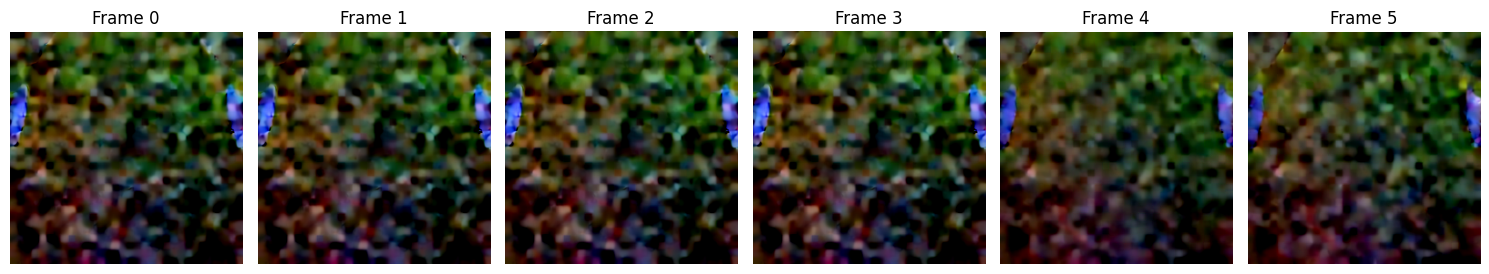

Inference Progress:  18%|█▊        | 9/50 [00:06<00:26,  1.56it/s]

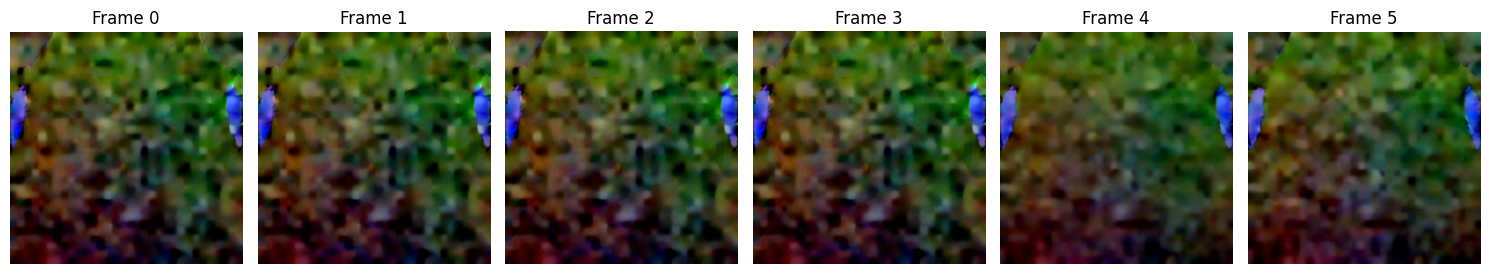

Inference Progress:  28%|██▊       | 14/50 [00:10<00:23,  1.55it/s]

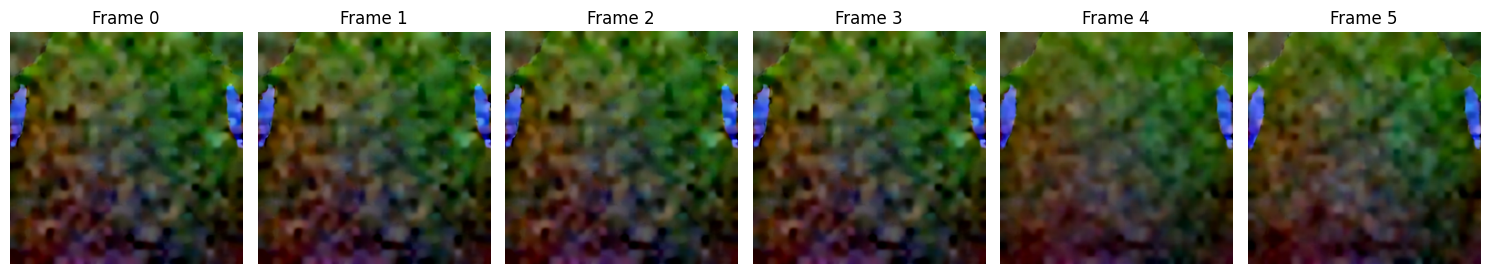

Inference Progress:  38%|███▊      | 19/50 [00:15<00:19,  1.56it/s]

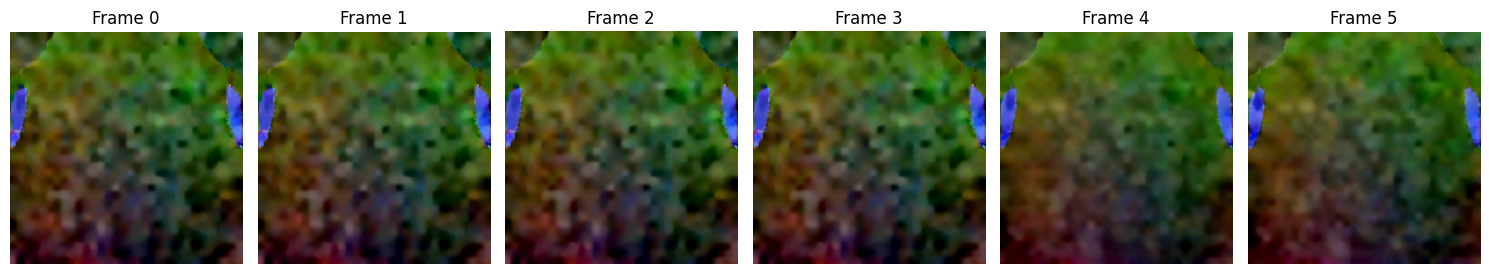

Inference Progress:  48%|████▊     | 24/50 [00:19<00:16,  1.54it/s]

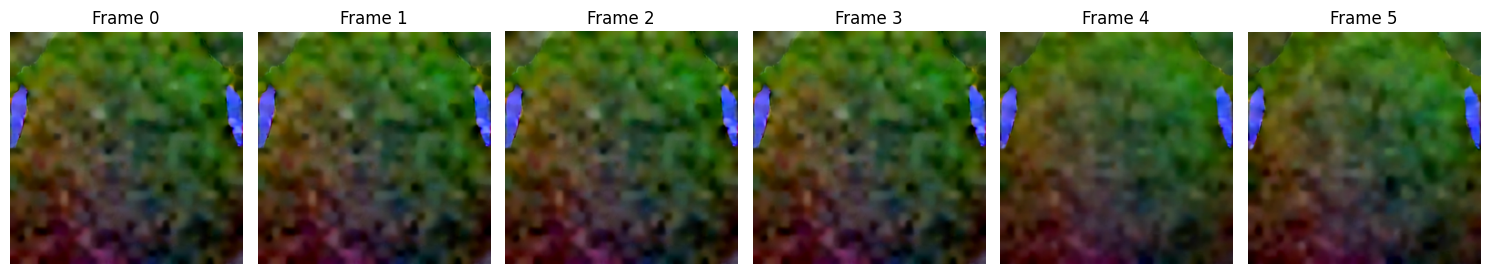

Inference Progress:  58%|█████▊    | 29/50 [00:24<00:14,  1.45it/s]

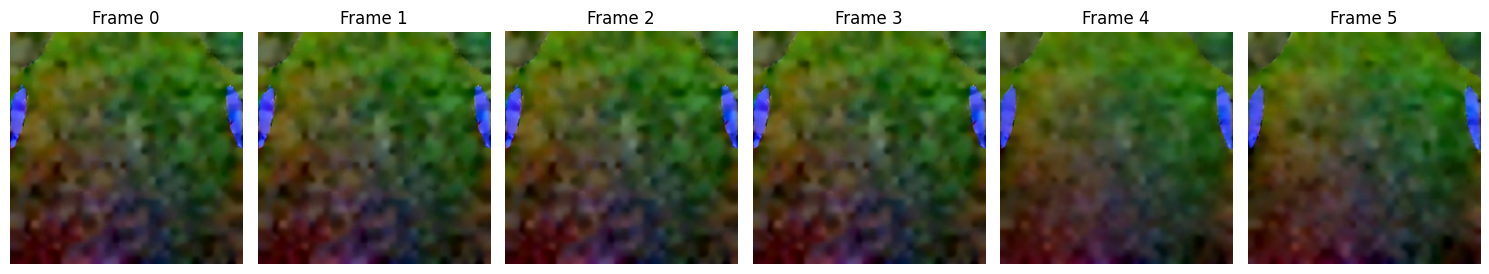

Inference Progress:  68%|██████▊   | 34/50 [00:28<00:10,  1.51it/s]

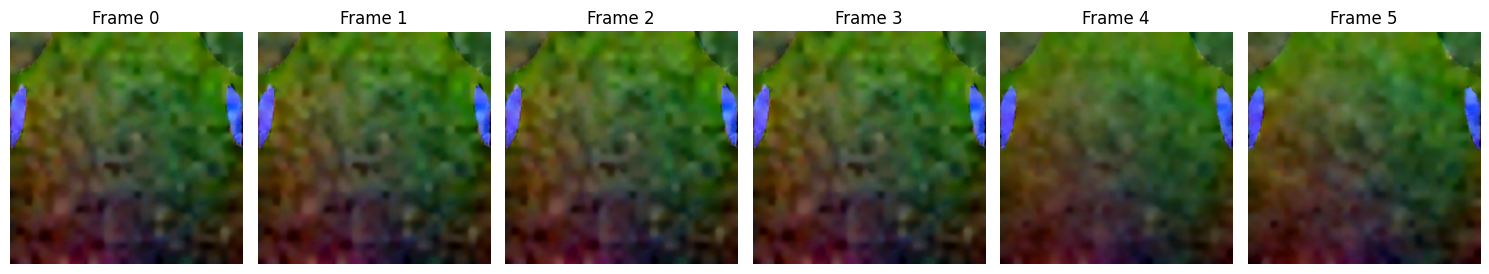

Inference Progress:  78%|███████▊  | 39/50 [00:33<00:07,  1.52it/s]

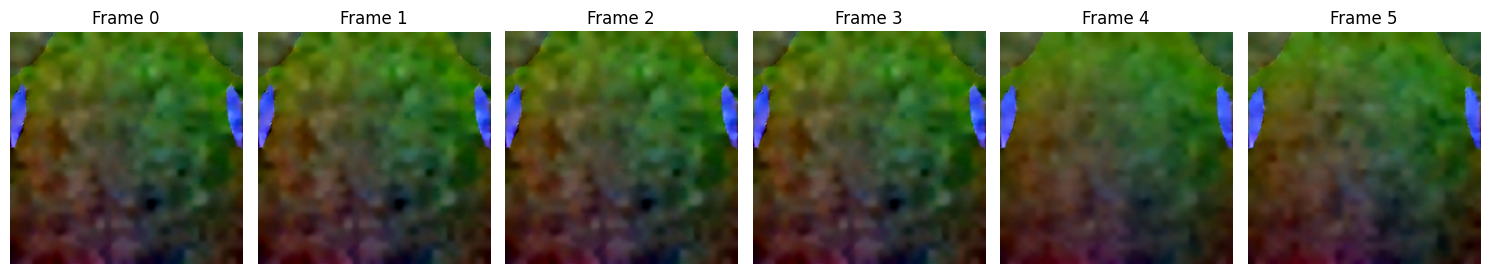

Inference Progress:  88%|████████▊ | 44/50 [00:37<00:03,  1.52it/s]

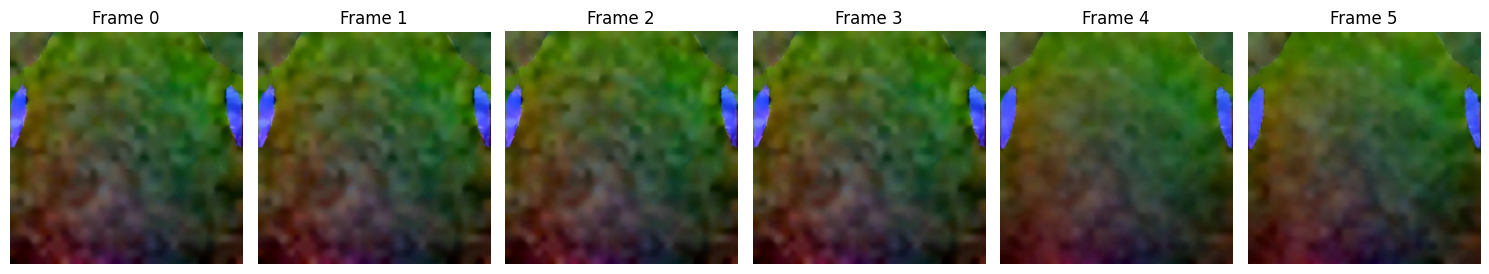

Inference Progress:  98%|█████████▊| 49/50 [00:41<00:00,  1.52it/s]

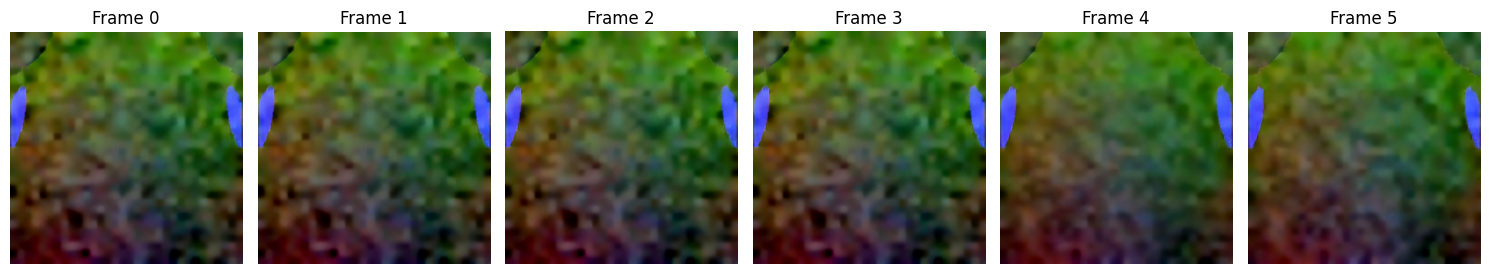

Inference Progress: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


In [12]:
%load_ext autoreload
%autoreload 2

from inference.inference_pipeline import *

pipe = VideoDiffusionPipeline(
    vae=vae,
    transformer=transformer,
    scheduler=scheduler
)
batch = next(iter(data_loader))
videos = pipe(batch, num_inference_steps=50, return_decode_latent=True, return_latent=False, sample_frames=args.sample_frames)

In [14]:
def save_video(video_tensor, path):
    video_tensor = video_tensor.squeeze(0)  # [3, 49, 256, 256]
    video_tensor = video_tensor.permute(1, 2, 3, 0)  # [49, 256, 256, 3]

    # Normalize to 0–255 and convert to uint8 if needed
    video_np = (video_tensor * 255).clamp(0, 255).byte().cpu().numpy()

    # Save as .mp4
    imageio.mimsave(path, video_np, fps=16)

save_video(videos[0] , "/scratch/ondemand28/harryscz/diffusion/videoOut/4000Out.mp4")

In [10]:
x = next(iter(data_loader))
save_video(x["video_chunks"][0] , "/scratch/ondemand28/harryscz/diffusion/videoOut/test_dataset.mp4")

In [11]:
x["video_chunks"][0].shape

torch.Size([1, 3, 435, 256, 256])

In [10]:
%load_ext autoreload
%autoreload 2

from model.flameObj import *

flamePath = flamePath = "/scratch/ondemand28/harryscz/head_audio/head/code/flame/flame2023_no_jaw.npz"
sourcePath = "/scratch/ondemand28/harryscz/head_audio/head/data/vfhq-fit"
dataPath = [os.path.join(os.path.join(sourcePath, data), "fit.npz") for data in os.listdir(sourcePath)]
seqPath = "/scratch/ondemand28/harryscz/head/_-91nXXjrVo_00/fit.npz"

head = Flame(flamePath, device=device)
head.loadSequence(dataPath[0]) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/nfs/horai.dgpsrv/ondemand28/harryscz/pytorch3d/pytorch3d/io/obj_io.py:551: UserWarning: Mtl file does not exist: /scratch/ondemand28/harryscz/head_audio/head/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [11]:
uv = videos[0][0].permute(1,2,3,0)
sampledUV = head.sampleFromUV(uv, "videoOut/400OutSampled.mp4", resolution=256) 
sampled3dSeq = head.sampleTo3D(sampledUV, "videoOut/400OutSampled3d.mp4", dist=0.01)  

In [13]:
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps
from tqdm import tqdm

In [17]:
from data.VideoDataset import video_collate 

train_dataset: VideoDataset = VideoDataset(
    "/scratch/ondemand28/harryscz/head_audio/data/data256/uv"
)

sampler = DistributedSampler(
    train_dataset, 
    num_replicas=accelerator.num_processes, 
    rank=accelerator.process_index, 
    shuffle=True
)
def worker_init_fn(worker_id):
    seed = torch.initial_seed() % (2**32)
    np.random.seed(seed)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    sampler=sampler, 
    collate_fn=video_collate,
    num_workers=16,
    worker_init_fn=worker_init_fn,
)

train_dataloader = accelerator.prepare(train_dataloader)

In [18]:
for idx, batch in enumerate(train_dataloader):
    if idx % 5 == 0: print(idx, batch["video_chunks"][0].shape)

0 torch.Size([3, 301, 256, 256])
5 torch.Size([3, 292, 256, 256])
10 torch.Size([3, 170, 256, 256])
15 torch.Size([3, 135, 256, 256])
20 torch.Size([3, 373, 256, 256])
25 torch.Size([3, 299, 256, 256])
30 torch.Size([3, 217, 256, 256])
35 torch.Size([3, 416, 256, 256])
40 torch.Size([3, 630, 256, 256])
45 torch.Size([3, 185, 256, 256])
50 torch.Size([3, 458, 256, 256])
55 torch.Size([3, 305, 256, 256])
60 torch.Size([3, 106, 256, 256])
65 torch.Size([3, 371, 256, 256])
70 torch.Size([3, 122, 256, 256])
75 torch.Size([3, 151, 256, 256])
80 torch.Size([3, 240, 256, 256])
85 torch.Size([3, 985, 256, 256])
90 torch.Size([3, 163, 256, 256])
95 torch.Size([3, 151, 256, 256])
100 torch.Size([3, 211, 256, 256])
105 torch.Size([3, 236, 256, 256])
110 torch.Size([3, 402, 256, 256])
115 torch.Size([3, 125, 256, 256])
120 torch.Size([3, 295, 256, 256])
125 torch.Size([3, 130, 256, 256])
130 torch.Size([3, 124, 256, 256])
135 torch.Size([3, 731, 256, 256])
140 torch.Size([3, 229, 256, 256])
145 tor